# 0. Load data

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb

# General utils
from tqdm import tqdm
from os import path

from measurements import get_prev_or_next_frame
from sklearn import preprocessing, model_selection, feature_selection, metrics, inspection, pipeline
from sklearn import ensemble, linear_model

def get_balanced_df_by_category(df,category):
    # assert(logical.dtype == bool)
    
    # Find the category with least members
    categories = {cat:mem for cat, mem in df.groupby(category)}
    num_per_category = np.array([len(mem) for mem in categories.values()])
    smallest_category = list(categories.keys())[num_per_category.argmin()]
    
    output = []
    for cat, member in categories.items():
        if cat == smallest_category:
            output.append(member)
        else:
            output.append(member.sample(num_per_category.min()))
    output = pd.concat(output,ignore_index=True)

    return output
    
def predict_feature(df:pd.DataFrame,
                    classifier,
                    feature2predict,
                    Niter:int=100,
                    rebalance:bool=True,
                    subsample=None,
                    measurement_level_name:str='Measurement'):
    if subsample == None:
        subsample = len(df)
    Y_test = []
    Y_pred = []
    models = []
    for i in tqdm(range(Niter)):

        # rng = np.random.RandomState(0)
        df_ = get_balanced_df_by_category(df, df[feature2predict,'Meta'].values)
        pipe = pipeline.make_pipeline(preprocessing.StandardScaler(),
                                      feature_selection.SelectFromModel(classifier()),
                                      classifier() )
        
        y = df_[feature2predict,'Meta'].astype(float)
        X = df_.xs(measurement_level_name,level=1,axis=1).astype(float)
        X[np.isinf(X)] = np.nan
        X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y)
        
        model = pipe.fit(X_train,y_train)
        models.append(model)
        
        Y_test.append(y_test)
        Y_pred.append(model.predict(X_test))
        
    return [np.stack((np.array(Y_test),np.array(Y_pred))),models]
    
import umap

# Suppress batch effects
def scale_by_region(df):
    scaled = []
    for region,_df in df.groupby('Region'):
        _X = preprocessing.StandardScaler().fit_transform(_df.drop(columns='Region'))
        _df = pd.DataFrame(index=_df.index,columns=_df.drop(columns='Region').columns,
                           data=_X)
        _df['Region'] = region
        scaled.append(_df)
    return pd.concat(scaled)
    

In [2]:
dataset_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Dataset pickles'
all_df = pd.read_pickle(path.join(dataset_dir,f'all_df.pkl'))
basals = all_df[all_df['Cell type','Meta'] == 'Basal']
basals = basals[~basals['Border','Meta'].astype(bool)]


### Separate measurement fields into constituent types
1. 'geom': Cell geometry
2. 'temporal': Cell rates and lookbacks
3. 'adjac': microenvironment/relative

In [3]:
# Filter only for geom features

meas_names = basals.xs('Measurement',level=1,axis=1).columns
meas_types = pd.DataFrame(index=meas_names)
meas_types['Type'] = 'geom'
meas_types.loc[ meas_names.str.contains('rate'),'Type' ] = 'temporal'
meas_types.loc[ meas_names.str.contains('prior'),'Type' ] = 'temporal'
meas_types.loc[ meas_names.str.contains('adjac'),'Type' ] = 'adjac'
meas_types.loc[ meas_names.str.contains('Relative'),'Type' ] = 'adjac'
meas_types.loc[ meas_names.str.contains('duration'),'Type' ] = 'temporal'
meas_types.loc[ meas_names.str.contains('duration'),'Type' ] = 'Time'
meas_types.loc[ meas_names.str.contains('neighbors'),'Type' ] = 'adjac'

cols2keep = [(f,'Measurement') for f in meas_types[meas_types['Type'] == 'geom'].index]
cols2keep += [(f,'Meta') for f in basals.xs('Meta',axis=1,level=1).columns]
cols2keep += [('Region','')]

basals = basals[cols2keep]

all_meas = basals.xs('Measurement',level=1,axis=1)
all_meas = all_meas.select_dtypes('number')
all_meas[np.isinf(all_meas)] = np.nan
all_meas = all_meas.dropna(axis=1)

all_meas['Region'] = basals['Region']
meas_scaled_by_region = scale_by_region(all_meas)
scaled_data = meas_scaled_by_region.drop(columns='Region')

# 1. Find UMAP configuration

### Try a bunch of hyperparameters

In [4]:
from itertools import product

_mapped = pd.DataFrame(index=basals.index)
_mapped['Region'] = basals['Region']
_mapped['Cell state'] = basals['Cell cycle phase','Meta']
_mapped.loc[basals['Birth frame','Meta'].astype(bool),'Cell state'] = 'Birth'
_mapped.loc[basals['Divide next frame','Meta'].astype(bool),'Cell state'] = 'Dividing'
_mapped.loc[basals['Will differentiate','Meta'].astype(bool),'Cell state'] = 'Differentiating'
# _mapped.loc[basals['Delaminate next frame','Meta'].astype(bool),'Cell state'] = 'Delaminating'

num_neighbors2try = [1,2,5,10,25,50]
min_dist2try = [0.0,0.1,0.2,0.5,0.8,1]
parameters = product(num_neighbors2try,min_dist2try)
mapped = []

for num_neighbors,min_dist in tqdm(parameters):
    
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(scaled_data)
    _this_mapped = _mapped.copy()
    
    _this_mapped['Umap1'] = embedding[:,0]
    _this_mapped['Umap2'] = embedding[:,1]
    _this_mapped['Num neighbors'] = num_neighbors
    _this_mapped['Min dist'] = min_dist

    mapped.append(_this_mapped)

mapped = pd.concat(mapped,ignore_index=True)

36it [01:44,  2.90s/it]


In [5]:
all_meas.shape

(8215, 110)

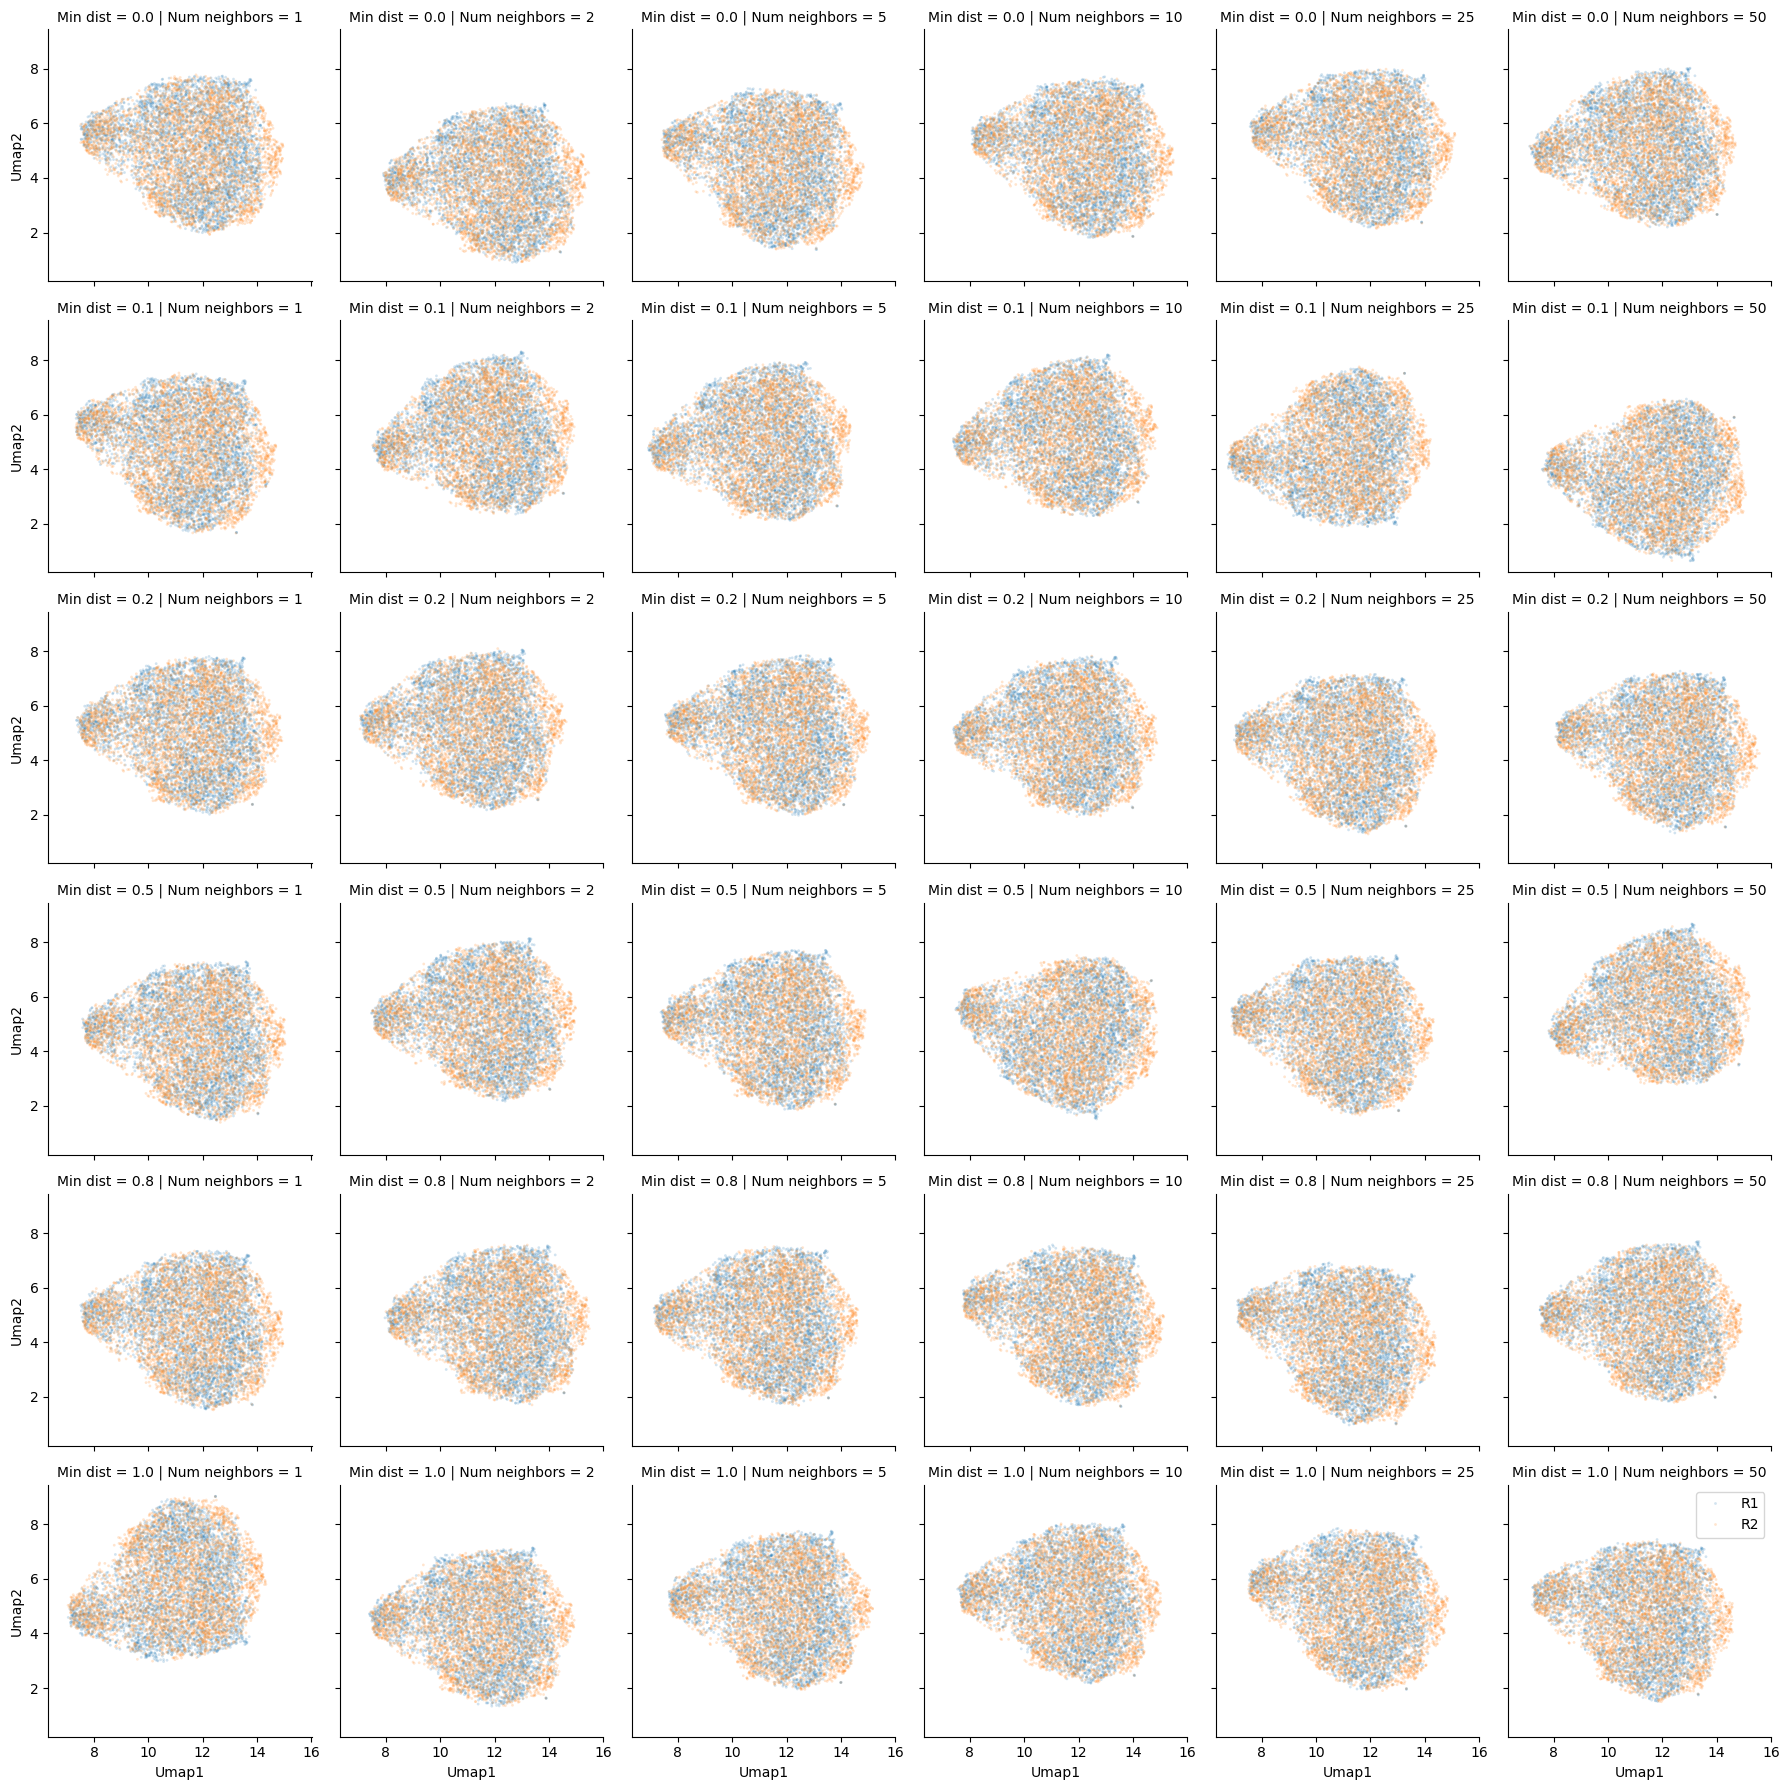

In [8]:
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 2              # <---- set markersize here
g = sb.FacetGrid(data=mapped,row='Min dist',col='Num neighbors')
g.map_dataframe(sb.scatterplot,data=mapped,x='Umap1',y='Umap2',
                hue='Region',alpha=0.2)
plt.legend()

It seems super robust

### Stability test

In [10]:
Niter = 6

_mapped = pd.DataFrame(index=basals.index)
_mapped['Region'] = basals['Region']
_mapped['Cell state'] = basals['Cell cycle phase','Meta']
_mapped.loc[basals['Birth frame','Meta'].astype(bool),'Cell state'] = 'Birth'
_mapped.loc[basals['Divide next frame','Meta'].astype(bool),'Cell state'] = 'Dividing'
_mapped.loc[basals['Will differentiate','Meta'].astype(bool),'Cell state'] = 'Differentiating'
# _mapped.loc[basals['Delaminate next frame','Meta'].astype(bool),'Cell state'] = 'Delaminating'

mapped = []
for i in tqdm(range(Niter)):
    
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(scaled_data)
    _this_mapped = _mapped.copy()
    
    _this_mapped['Umap1'] = embedding[:,0]
    _this_mapped['Umap2'] = embedding[:,1]
    _this_mapped['Umap run'] = i

    mapped.append(_this_mapped)

mapped = pd.concat(mapped,ignore_index=True)

100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.17s/it]


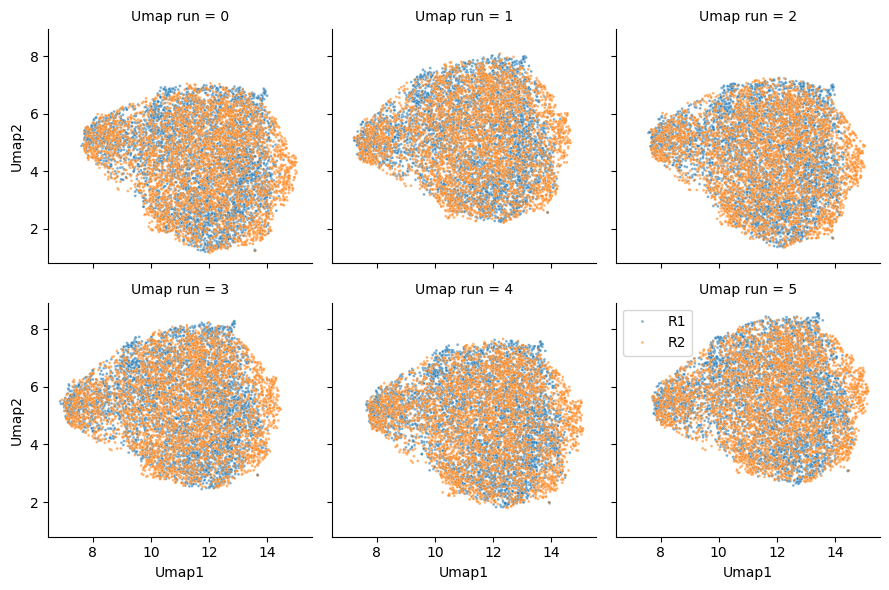

In [11]:
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 2              # <---- set markersize here
g = sb.FacetGrid(data=mapped,col_wrap=3,col='Umap run')
g.map_dataframe(sb.scatterplot,data=mapped,x='Umap1',y='Umap2',
                hue='Region',alpha=0.6)
plt.legend()

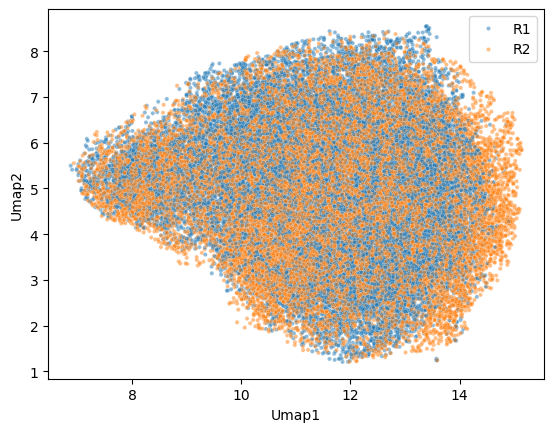

In [12]:
mpl.rcParams['lines.markersize'] = 3              # <---- set markersize here

sb.scatterplot(data=mapped[mapped['Cell state'] != 'NA'],x='Umap1',y='Umap2',
                hue='Region',alpha=0.5,)
               # size='Cell state',
               # size_order=['Birth','Dividing','Differentiating','SG2','G1'])
plt.legend(bbox_to_anchor=(1,1))


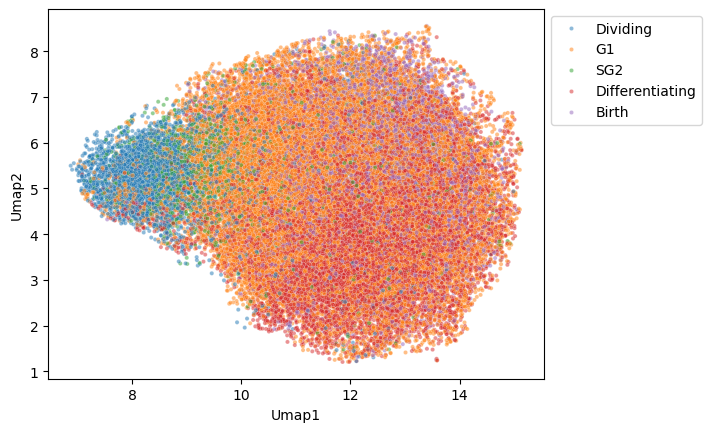

In [14]:
mpl.rcParams['lines.markersize'] = 3              # <---- set markersize here

sb.scatterplot(data=mapped[mapped['Cell state'] != 'NA'],x='Umap1',y='Umap2',
                hue='Cell state',alpha=0.5)
               # size='Cell state',
               # size_order=['Birth','Dividing','Differentiating','SG2','G1'])
plt.legend(bbox_to_anchor=(1,1))


Basicallly, all UMAP runs returns similar graphs

## Visualize UMAPs alongside cell state annotation

In [16]:
mpl.rcParams['lines.markersize'] = 5              # <---- set markersize here

all_meas = basals.xs('Measurement',level=1,axis=1)
all_meas = all_meas.select_dtypes('number')
all_meas[np.isinf(all_meas)] = np.nan
all_meas = all_meas.dropna(axis=1)

all_meas['Region'] = basals['Region']
meas_scaled_by_region = scale_by_region(all_meas)
scaled_data = meas_scaled_by_region.drop(columns='Region')

reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_data)

basals['Umap1'] = embedding[:,0]
basals['Umap2'] = embedding[:,1]


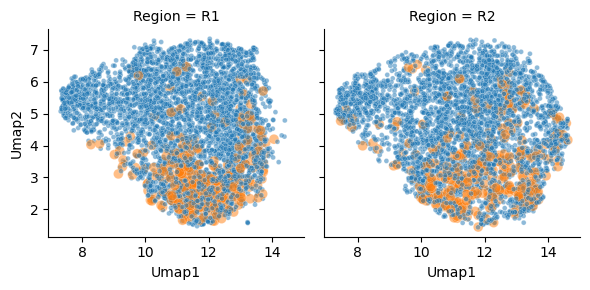

In [17]:
g = sb.FacetGrid(data= basals.droplevel(axis=1,level=1),col='Region')
g.map_dataframe(sb.scatterplot, data = basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',hue='Delaminate next frame',alpha=0.5,
              size='Delaminate next frame', size_order=[True,False])

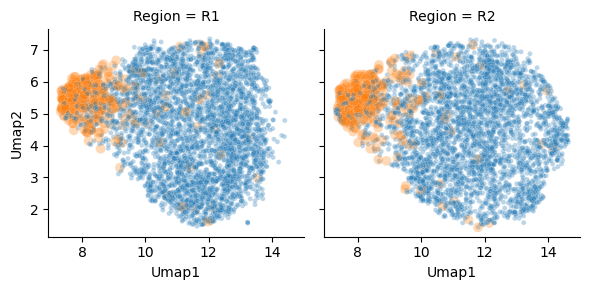

In [18]:

g = sb.FacetGrid(data= basals.droplevel(axis=1,level=1),col='Region')

g.map_dataframe(sb.scatterplot,data=basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',hue='Divide next frame',alpha=0.3,
              size='Divide next frame', size_order=[True,False])


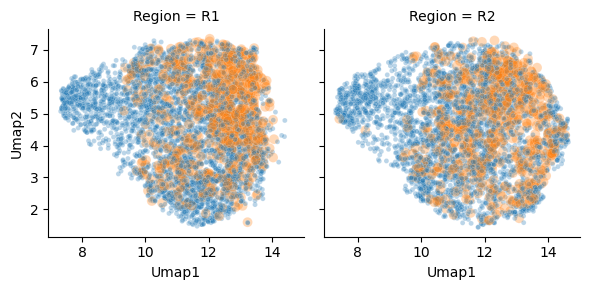

In [19]:

g = sb.FacetGrid(data= basals.droplevel(axis=1,level=1),col='Region')

g.map_dataframe(sb.scatterplot,data=basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',hue='Birth frame',alpha=0.3,
              size='Birth frame', size_order=[True,False])


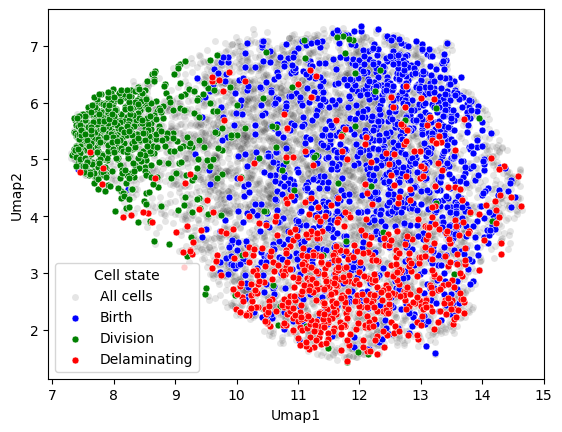

In [27]:
fig, ax = plt.subplots()

sb.scatterplot(basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',alpha=0.1, ax=ax, color='k')
sb.scatterplot(basals[basals['Birth frame','Meta']].droplevel(axis=1,level=1),x='Umap1',y='Umap2',color='b',ax=ax)

sb.scatterplot(basals[basals['Divide next frame','Meta']].droplevel(axis=1,level=1),x='Umap1',y='Umap2',color='g',ax=ax)

sb.scatterplot(basals[basals['Delaminate next frame','Meta']].droplevel(axis=1,level=1),x='Umap1',y='Umap2',color='r',ax=ax)

plt.legend(title='Cell state',labels=['All cells','Birth','Division','Delaminating'])


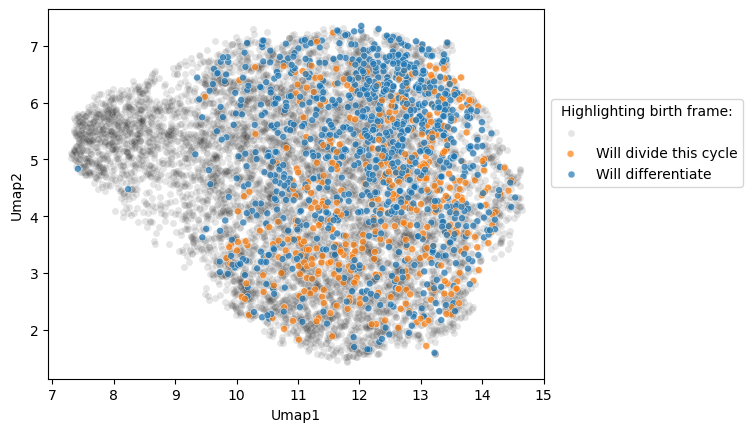

In [29]:
mpl.rcParams['lines.markersize'] = 5              # <---- set markersize here

fig, ax = plt.subplots()

sb.scatterplot(basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',color='k',alpha=0.1,ax=ax)
_df = basals[basals['Birth frame','Meta']]
sb.scatterplot(_df.droplevel(axis=1,level=1),
               x='Umap1',y='Umap2',alpha=0.7, ax=ax, hue='Will differentiate')

plt.legend(title='Highlighting birth frame:', loc='lower left',
           labels=['','Will divide this cycle', 'Will differentiate'],
          bbox_to_anchor=(1, 0.5))

<Axes: xlabel='Umap1', ylabel='Umap2'>

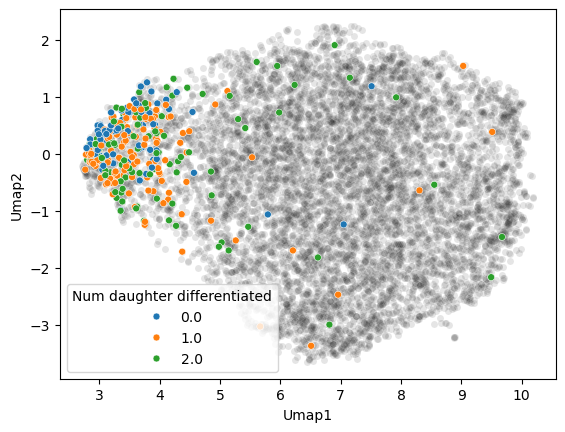

In [128]:
fig, ax = plt.subplots()

sb.scatterplot(basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',color='k',alpha=0.1,ax=ax)
_df = basals[basals['Divide next frame','Meta']]
sb.scatterplot(_df.droplevel(axis=1,level=1), palette='tab10',
               x='Umap1',y='Umap2',alpha=1, ax=ax, hue='Num daughter differentiated')

# plt.legend(title='Highlighting division frame:', loc='lower left',
#            labels=['','Two dividing daughters','Asymmetric daughters', 'Two differentiating'],
#           bbox_to_anchor=(0, 1))

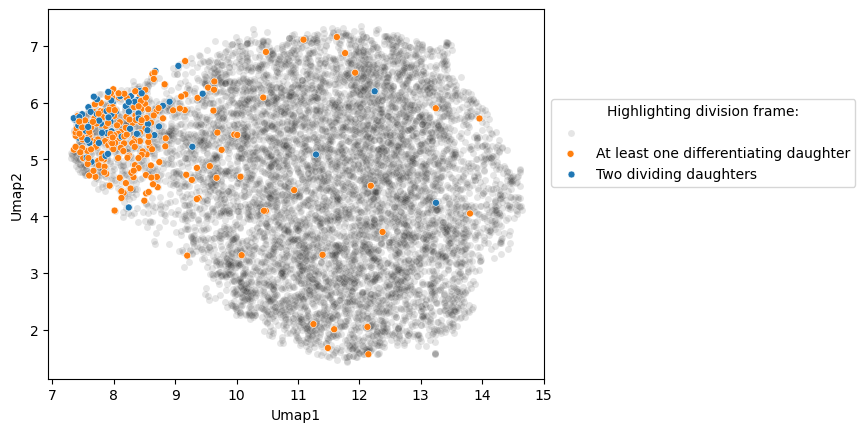

In [30]:
fig, ax = plt.subplots()

sb.scatterplot(basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',color='k',alpha=0.1,ax=ax)
_df = basals[basals['Divide next frame','Meta']]
sb.scatterplot(_df.droplevel(axis=1,level=1), palette='tab10',
               x='Umap1',y='Umap2',alpha=1, ax=ax, hue='At least one daughter differentiated',
              hue_order=[False,True])

plt.legend(title='Highlighting division frame:', loc='lower left',
           labels=['','At least one differentiating daughter','Two dividing daughters'],
          bbox_to_anchor=(1, 0.5))

## Isolated frames -> then UMAP

This seems unstable and probably highly dependent on hyperparameters.. did not explore yet

In [44]:
births = births[~births['Border','Meta'].astype(bool)]
divisions = divisions[~divisions['Border','Meta'].astype(bool)]

<Axes: xlabel='Umap1', ylabel='Umap2'>

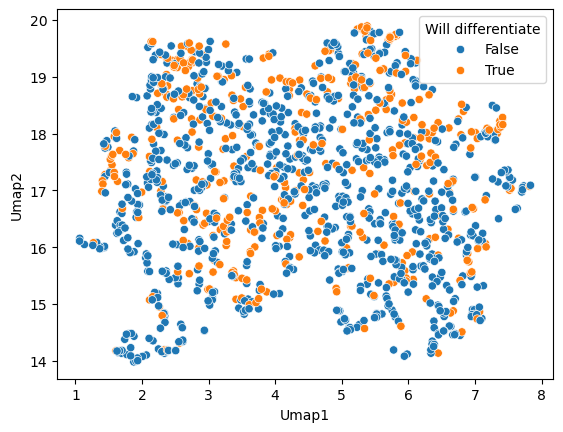

In [47]:
reducer = umap.UMAP()
all_meas = births.xs('Measurement',level=1,axis=1)
all_meas = all_meas.select_dtypes('number')
all_meas[np.isinf(all_meas)] = np.nan
all_meas = all_meas.dropna(axis=1)

scaled_df = preprocessing.StandardScaler().fit_transform(all_meas)
embedding = reducer.fit_transform(scaled_df)
embedding.shape
births['Umap1','Umap'] = embedding[:,0]
births['Umap2','Umap'] = embedding[:,1]

fig, ax = plt.subplots()

sb.scatterplot(births.droplevel(axis=1,level=1),
               x='Umap1',y='Umap2', ax=ax, hue='Will differentiate')


In [41]:
reducer = umap.UMAP()
all_meas = divisions.xs('Measurement',level=1,axis=1)
all_meas = all_meas.select_dtypes('number')
all_meas[np.isinf(all_meas)] = np.nan
all_meas = all_meas.dropna(axis=1)

scaled_df = preprocessing.StandardScaler().fit_transform(all_meas)
embedding = reducer.fit_transform(scaled_df)
embedding.shape
divisions['Umap1','Umap'] = embedding[:,0]
divisions['Umap2','Umap'] = embedding[:,1]
fig, ax = plt.subplots()

sb.scatterplot(divisions.droplevel(axis=1,level=1),
               x='Umap1',y='Umap2', ax=ax, hue='Num daughter differentiated')


<Axes: xlabel='Umap1', ylabel='Umap2'>

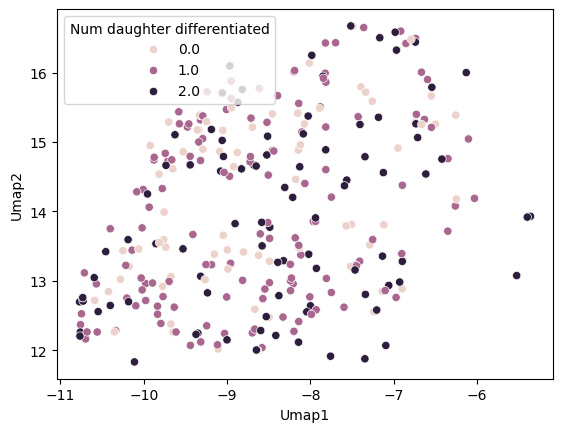